# ResNet Implementation with TensorFlow

## Download CIFAR10

In [1]:
import numpy as np
from tensorflow.keras.datasets.cifar10 import load_data

In [2]:
(trainX, trainY), (testX, testY) = load_data()

In [3]:
print(trainX.shape)
print(testX.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
print(trainY.shape)
print(testY.shape)

(50000, 1)
(10000, 1)


In [5]:
train_num = int(len(trainX)*0.9)
valid_num = len(trainX) - train_num

In [6]:
p = np.random.permutation(50000)

trainX = trainX[p]
trainY = trainY[p]

validX = trainX[-valid_num:] / 255
validY = trainY[-valid_num:] 

trainX = trainX[:train_num] / 255
trainY = trainY[:train_num] 

testX = testX / 255
testY = testY

## Construct Model

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, MaxPool2D, Dense
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
def make_basic_residual(num_filters, stride):
    def f(x):
        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=stride, padding='same',
                   activation=None,
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters,
                   kernel_size=(3,3),
                   strides=1, padding='same',
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        
        return x
    
    return f

def BasicBlock(num_filters, stride):
    def f(x):
        y = make_basic_residual(num_filters, stride)(x)
        
        if stride!=1 or x.shape[-1] != num_filters:
            x = Conv2D(filters=num_filters, 
                       kernel_size=(1,1), 
                       strides=stride, padding='same', 
                       activation=None,
                       use_bias=True, kernel_initializer='he_normal')(x)
        return add([x,y])
    return f

In [9]:
def make_bottleneck_residual(num_filters, stride):
    def f(x):
        x = Conv2D(filters=num_filters//4, 
                   kernel_size=(1,1), 
                   strides=stride, padding='same', 
                   activation=None, 
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters//4, 
                   kernel_size=(3,3), 
                   strides=1, padding='same', 
                   activation=None, 
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = relu(x)
        x = Conv2D(filters=num_filters, 
                   kernel_size=(1,1), 
                   strides=1, padding='same', 
                   activation=None, 
                   use_bias=False, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        
        return x
    return f

def BottleneckBlock(num_filters, stride):
    def f(x):
        y = make_bottleneck_residual(num_filters, stride)(x)
        
        if stride!=1 or x.shape[-1] != num_filters:
            x = Conv2D(filters=num_filters, 
                       kernel_size=(1,1), 
                       strides=stride, padding='same', 
                       activation=None,
                       use_bias=True, kernel_initializer='he_normal')(x)
            
        return add([x,y])
    return f

In [10]:
def make_ResNet(channels, input_shape, block='basic'):
    
    input_tensor=Input(input_shape)
    x = Conv2D(filters=channels[0], kernel_size=(3,3), padding='same', 
               activation=None, use_bias=False, kernel_initializer='he_uniform')(input_tensor)
    x = BatchNormalization()(x)
    x = relu(x)
    
    if block=='basic':
        x = BasicBlock(channels[0], stride=1)(x)
        x = BasicBlock(channels[1], stride=2)(x)
        x = BasicBlock(channels[2], stride=1)(x)
        x = BasicBlock(channels[3], stride=2)(x)
        x = BasicBlock(channels[4], stride=2)(x)
        x = BasicBlock(channels[5], stride=1)(x)
        
    elif block == 'bottleneck':
        x = BottleneckBlock(channels[0], stride=1)(x)
        x = BottleneckBlock(channels[1], stride=2)(x)
        x = BottleneckBlock(channels[2], stride=1)(x)
        x = BottleneckBlock(channels[3], stride=2)(x)
        x = BottleneckBlock(channels[4], stride=2)(x)
        x = BottleneckBlock(channels[5], stride=1)(x)
        
    else:
        raise ValueError
        
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(channels[5]//4, activation=None, use_bias=False, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    x = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)

    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model
    

In [11]:
input_shape = trainX.shape[1:]

## Basic ResNet Model

In [12]:
basic_model = make_ResNet(channels=[16,16,32,64,128,128], input_shape=input_shape, block='basic')

In [13]:
basic_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
tf.nn.relu (TFOpLambda)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr = LearningRateScheduler(lambda epoch: 0.01*(0.5**int(epoch//10))*(0.95 ** epoch), verbose=1)

In [15]:
EPOCHS=50

history=basic_model.fit(trainX, trainY, batch_size=128, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 9s 12ms/step - loss: 1.8067 - accuracy: 0.3206 - val_loss: 1.6848 - val_accuracy: 0.4170
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0095.
352/352 [==============================] - 3s 9ms/step - loss: 1.2510 - accuracy: 0.5400 - val_loss: 2.3573 - val_accuracy: 0.3290
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009025.
352/352 [==============================] - 3s 9ms/step - loss: 1.0290 - accuracy: 0.6297 - val_loss: 2.8135 - val_accuracy: 0.3646
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00857375.
352/352 [==============================] - 3s 9ms/step - loss: 0.8952 - accuracy: 0.6817 - val_loss: 1.5242 - val_accuracy: 0.5302
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0081450625.
352/352 [==============================] - 3s 10ms/step - lo

352/352 [==============================] - 5s 13ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 1.4682 - val_accuracy: 0.7858
Epoch 38/50

Epoch 00038: LearningRateScheduler reducing learning rate to 0.00018736281756101932.
352/352 [==============================] - 4s 12ms/step - loss: 0.0012 - accuracy: 0.9999 - val_loss: 1.4626 - val_accuracy: 0.7870
Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00017799467668296834.
352/352 [==============================] - 5s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4849 - val_accuracy: 0.7860
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.0001690949428488199.
352/352 [==============================] - 5s 14ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.4823 - val_accuracy: 0.7902
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 8.032009785318945e-05.
352/352 [==============================] - 4s 13ms/step - loss: 0.0012 - accuracy:

In [16]:
test_loss, test_acc = basic_model.evaluate(testX, testY, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 1.5403 - accuracy: 0.7846


## Plot Training Loss and Validation loss 

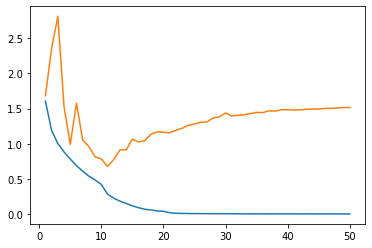

In [17]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['loss'])
plt.plot(np.arange(1, EPOCHS+1), history.history['val_loss'])
plt.show()

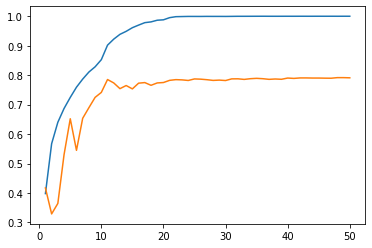

In [18]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'])
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'])
plt.show()

## Bottleneck ResNet Model

In [19]:
bottleneck_model = make_ResNet(channels=[16,16,32,64,128,128], input_shape=input_shape, block='bottleneck')

In [20]:
bottleneck_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 32, 16)   64          conv2d_17[0][0]                  
__________________________________________________________________________________________________
tf.nn.relu_8 (TFOpLambda)       (None, 32, 32, 16)   0           batch_normalization_14[0][0]     
____________________________________________________________________________________________

In [21]:
EPOCHS=50

history2=bottleneck_model.fit(trainX, trainY, batch_size=128, epochs=EPOCHS, validation_data=(validX, validY), callbacks=[lr])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
352/352 [==============================] - 9s 18ms/step - loss: 1.8160 - accuracy: 0.3277 - val_loss: 2.0557 - val_accuracy: 0.3464
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0095.
352/352 [==============================] - 5s 15ms/step - loss: 1.3772 - accuracy: 0.4875 - val_loss: 1.6079 - val_accuracy: 0.4362
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009025.
352/352 [==============================] - 5s 15ms/step - loss: 1.2102 - accuracy: 0.5592 - val_loss: 1.4209 - val_accuracy: 0.5028
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00857375.
352/352 [==============================] - 5s 15ms/step - loss: 1.0972 - accuracy: 0.6068 - val_loss: 1.3976 - val_accuracy: 0.5382
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0081450625.
352/352 [==============================] - 5s 15ms/step -

352/352 [==============================] - 5s 15ms/step - loss: 0.4485 - accuracy: 0.8463 - val_loss: 1.0035 - val_accuracy: 0.6900
Epoch 38/50

Epoch 00038: LearningRateScheduler reducing learning rate to 0.00018736281756101932.
352/352 [==============================] - 5s 15ms/step - loss: 0.4535 - accuracy: 0.8405 - val_loss: 1.0020 - val_accuracy: 0.6906
Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 0.00017799467668296834.
352/352 [==============================] - 5s 15ms/step - loss: 0.4459 - accuracy: 0.8446 - val_loss: 1.0085 - val_accuracy: 0.6920
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 0.0001690949428488199.
352/352 [==============================] - 5s 14ms/step - loss: 0.4413 - accuracy: 0.8477 - val_loss: 1.0091 - val_accuracy: 0.6858
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 8.032009785318945e-05.
352/352 [==============================] - 5s 15ms/step - loss: 0.4377 - accuracy:

In [22]:
test_loss, test_acc = bottleneck_model.evaluate(testX, testY, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 1.0269 - accuracy: 0.6946


## Plot Training Loss and Validation loss 

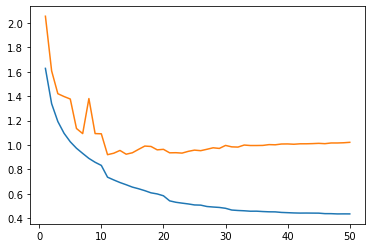

In [23]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history2.history['loss'])
plt.plot(np.arange(1, EPOCHS+1), history2.history['val_loss'])
plt.show()

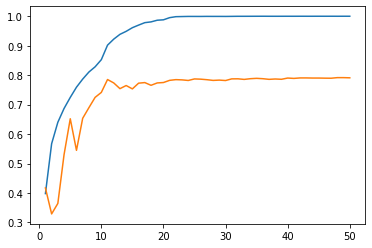

In [24]:
plt.figure()
plt.plot(np.arange(1, EPOCHS+1), history.history['accuracy'])
plt.plot(np.arange(1, EPOCHS+1), history.history['val_accuracy'])
plt.show()